In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler  
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

from keras. utils.vis_utils import plot_model


In [3]:
def plotar_testes(y_test,y_pred,modelo):
    #Predicted vs True Adj Close Value – LSTM
    plt.plot(y_test.values.ravel(), label='Valor real')
    plt.plot(y_pred, label= f'{modelo} predição')
    plt.xticks(range(0,y_test.shape[0],5000),y_test.index[::5000],rotation=45)
    plt.title(f'Predição usando {modelo}')
    plt.xlabel('Tempo')
    plt.ylabel('Valor ação')
    plt.legend()
    plt.savefig(f"grafico_train_test.png",dpi=300, bbox_inches='tight')
    plt.show()

def plotar_testes_1000(y_test,y_pred,tam,modelo):
    #Predicted vs True Adj Close Value – LSTM
    base = int(tam*0.1)
    plt.plot(y_test[-tam:-1].values.ravel(), label='Valor real')
    plt.plot(y_pred[-tam:-1], label= f'{modelo} predição')
    plt.xticks(range(0,y_test[-tam:-1].shape[0],base),y_test[-tam:-1].index[::base],rotation=45)
    plt.title(f'Predição usando {modelo}')
    plt.xlabel('Tempo')
    plt.ylabel('Valor ação')
    plt.legend()
    plt.savefig(f"-1000.png",dpi=300, bbox_inches='tight')
    plt.show()

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error


def erros(y_test, y_pred):
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"MAPE: {mape*100:.5f}%")
    
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE: {mse:.2f}")

In [4]:
#data = pd.read_csv("../input/winq22/WINQ22_SPREAD_1.csv",sep=";")
data = pd.read_csv("../input/winq22-process/submission_example.csv",
                  #skiprows = range(30001, 3119977), # ignora as primeiras 10 linhas do excel
                  )
df = pd.DataFrame(data)
# df = df.reset_index()
df.shape

#Criando o Dataframe
df.sort_index(ascending=True, axis=0)
data = df.sort_index(ascending=True, axis=0)

#Colocando data como índice
df.index = df.Date
df.drop('Date', axis=1, inplace=True)

df.head()

df['mm5d'] = df['Close'].rolling(5).mean()
df['mm21d'] = df['Close'].rolling(21).mean()

#retirando os dados nulos
df.dropna(inplace=True)
df

,Open,Hight,Low,Close,Ticket,Volume,mm5d,mm21d
Date,,,,,,,,
2022-08-09 09:03:20,109025.0,109030.0,108970.0,109015.0,4384,11805,109011.0,108994.523810
2022-08-09 09:03:21,109025.0,109030.0,108970.0,109005.0,4488,12000,109010.0,108993.333333
2022-08-09 09:03:22,109025.0,109030.0,108970.0,108985.0,4777,12855,109004.0,108991.428571
2022-08-09 09:03:23,109025.0,109030.0,108970.0,108985.0,4847,12961,108999.0,108991.428571
2022-08-09 09:03:24,109025.0,109030.0,108970.0,108980.0,4983,13308,108994.0,108990.952381
...,...,...,...,...,...,...,...,...
2022-08-15 17:50:55,113265.0,113280.0,113235.0,113235.0,2271,7924,113240.0,113241.428571
2022-08-15 17:50:56,113265.0,113280.0,113230.0,113230.0,2377,8206,113238.0,113240.476190
2022-08-15 17:50:57,113265.0,113280.0,113230.0,113235.0,2409,8287,113236.0,113240.000000


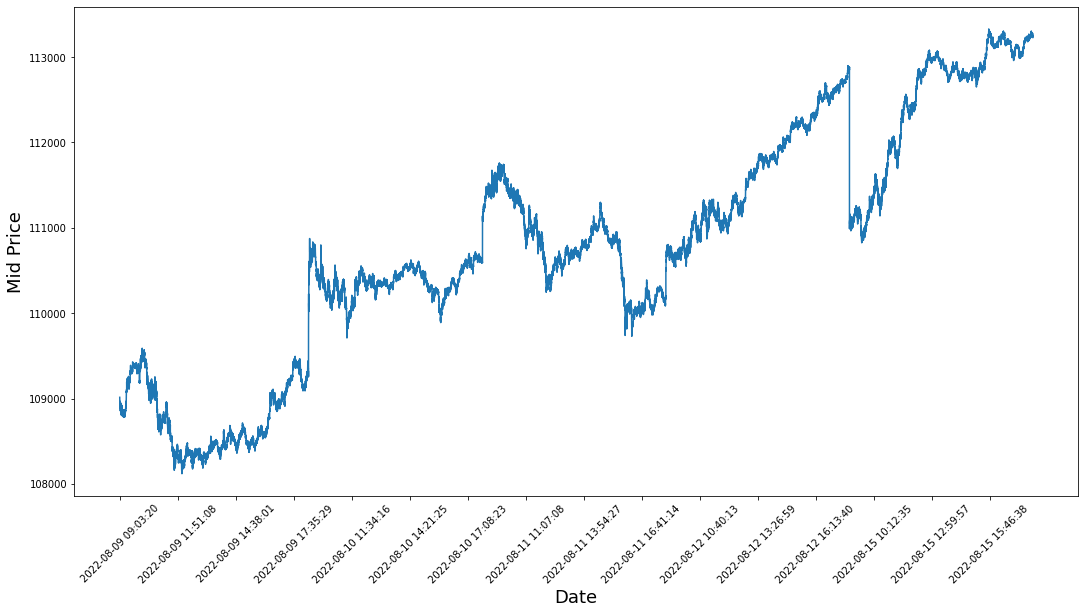

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Close']))
plt.xticks(range(0,df.shape[0],10000),df.index[::10000],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [6]:
#Importando as libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# ==============================================

In [7]:
features = df.loc[:,['Open', 'Hight', 'Low', 'Ticket','Volume','mm5d','mm21d']]
y_output = df['Close']

In [8]:
split_percentage = 0.7
split = int(split_percentage*len(df))
  
# Train data set
X_train = features[:split]
y_train = y_output[:split]
  
# Test data set
X_test = features[split:]
y_test = y_output[split:]

print( len(X_train), len(y_train))
print( len(X_test), len(y_test))

110222 110222
47238 47238


In [9]:
# # Normalizando os dados de entrada(features)

# # Gerando o novo padrão
# scaler = StandardScaler()
# X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
# X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

In [10]:
# Normalizando os dados de entrada(features)

# Gerando o novo padrão
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

In [11]:
print(X_train.shape, X_test.shape)

(110222, 7) (47238, 7)


In [12]:
#Process the data for LSTM
trainX =np.array(X_train_scale)
testX =np.array(X_test_scale)
X_train = trainX.reshape(X_train_scale.shape[0], 1, X_train_scale.shape[1])
X_test = testX.reshape(X_test_scale.shape[0], 1, X_test_scale.shape[1])

2022-09-13 00:07:26.371424: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


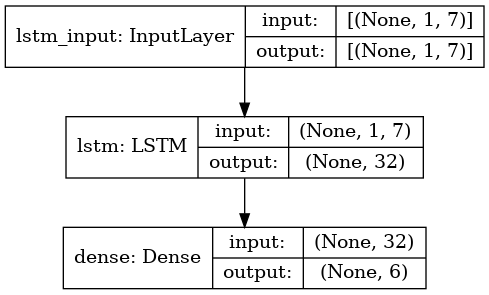

In [13]:
# Criando o modelo LSTM
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))

# model.add(LSTM(units=50))
from keras.layers import Input

output_size = 6

model = Sequential()
model.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
model.add(Dense(output_size))
model.compile(loss='mean_squared_error', optimizer='adam')
plot_model(model, show_shapes=True, show_layer_names=True)

In [14]:
epocas = 66
history = model.fit(X_train, y_train.values.ravel(), 
                    epochs=epocas,validation_data=(X_test, y_test), 
                    batch_size=8, verbose=1, shuffle=False)


2022-09-13 00:07:27.844562: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/66
13778/13778 [==============================] - 32s 2ms/step - loss: 10595612672.0000 - val_loss: 6817369600.0000
Epoch 2/66
13778/13778 [==============================] - 33s 2ms/step - loss: 6053666304.0000 - val_loss: 475566848.0000
Epoch 3/66
13778/13778 [==============================] - 32s 2ms/step - loss: 2233762816.0000 - val_loss: 1812325632.0000
Epoch 4/66
13778/13778 [==============================] - 31s 2ms/step - loss: 1247486848.0000 - val_loss: 2185448192.0000
Epoch 5/66
13778/13778 [==============================] - 32s 2ms/step - loss: 1174045952.0000 - val_loss: 2108220672.0000
Epoch 6/66
13778/13778 [==============================] - 30s 2ms/step - loss: 1129838080.0000 - val_loss: 2017152256.0000
Epoch 7/66
13778/13778 [==============================] - 30s 2ms/step - loss: 1086335360.0000 - val_loss: 1925696768.0000
Epoch 8/66
13778/13778 [==============================] - 30s 2ms/step - loss: 1042695424.0000 - val_loss: 1834290304.0000
Epoch 9/66
13778

In [15]:
X_test_2 = X_test[range(0,len(X_test),output_size)]


In [16]:

y_pred= model.predict(X_test_2)
y_pred.shape
y_pred2 = np.reshape(y_pred,(len(y_test),1))
y_pred2.shape

(47238, 1)

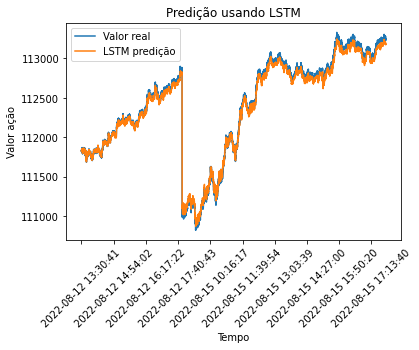

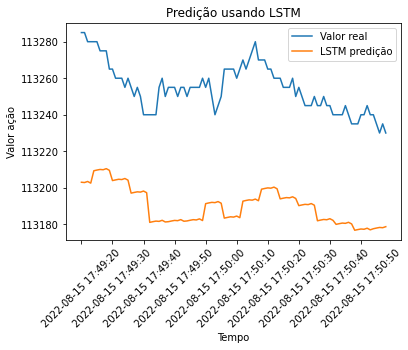

MAPE: 0.03025%
MSE: 1714.67


In [17]:
# #LSTM Prediction
# #y_pred= model.predict(X_test.reshape((1,3,1)))
# y_pred= model.predict(X_test)
# # print(y_pred)
# # plt.plot(y_pred)
plotar_testes(y_test,y_pred2,'LSTM')
plotar_testes_1000(y_test,y_pred2,100,'LSTM')
erros(y_test, y_pred2)

In [18]:
y_test

Date
2022-08-12 13:30:41    111830.0
2022-08-12 13:30:42    111830.0
2022-08-12 13:30:43    111825.0
2022-08-12 13:30:44    111830.0
2022-08-12 13:30:45    111825.0
                         ...   
2022-08-15 17:50:55    113235.0
2022-08-15 17:50:56    113230.0
2022-08-15 17:50:57    113235.0
2022-08-15 17:50:58    113230.0
2022-08-15 17:50:59    113230.0
Name: Close, Length: 47238, dtype: float64

In [19]:
from tensorflow.keras.models import save_model
save_model(model, "model.h5")

In [20]:
# from keras.models import load_model
# model = load_model('../input/model-save/stund_split_10.h5')

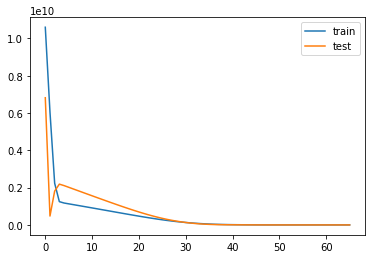

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

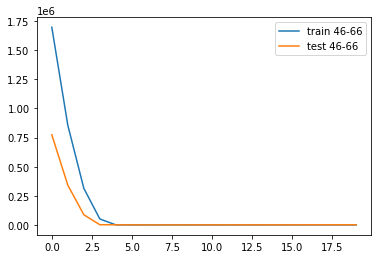

In [22]:
high = epocas
low = epocas-20

plt.plot(history.history['loss'][low:high], label=f'train {low}-{high}')
plt.plot(history.history['val_loss'][low:high], label=f'test {low}-{high}')
plt.legend()
plt.show()

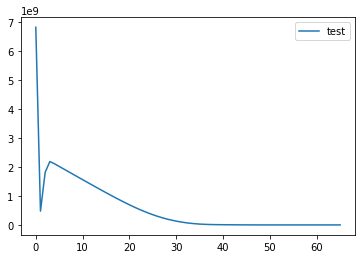

In [23]:
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()